In [38]:
import pyodbc 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [39]:
def wrangle(db):
    # Connect to database
    conn = pyodbc.connect(db)

    # retrieve only buildings that are in Gorkha(Gorkha (district 4)) and the damage_grade
    query = """
    SELECT DISTINCT (i.building_id) as b_id,s.*,d.damage_grade
    FROM id_map$ as i
    JOIN building_structure$ as s on i.building_id=s.building_id
    JOIN building_damage$ as d on i.building_id=d.building_id
    where district_id = 4
    """
    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [40]:
# Prepare Data
# Import
df=wrangle('Driver={SQL Server};'
        'Server=DESKTOP-C6O0T9S;'
        'Database=PortfolioProject;'
        'Trusted_Connection=yes;')
df.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12512\1134671470.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, index_col="b_id")


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
168543.0,16.0,238.0,13.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
230318.0,26.0,528.0,15.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
230621.0,22.0,190.0,14.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"Stone, mud mortar",1
231199.0,70.0,300.0,16.0,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
168427.0,5.0,365.0,18.0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


In [41]:
#Split
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [42]:
# training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [43]:
# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

In [44]:
# Build Model
# Baseline
# the baseline accuracy score
acc_baseline = df[target].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


In [45]:
# Iterate
model = make_pipeline(
    OrdinalEncoder(),DecisionTreeClassifier(max_depth=6,random_state=42)
) 
model.fit(X_train,y_train)
check_is_fitted(model)


In [46]:
# the training and validation accuracy scores
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_val = model.score(X_val,y_val)
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.72
Validation Accuracy: 0.71


In [47]:
# the get_depth method on the DecisionTreeClassifier
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 6


In [48]:
depth_hyperparams = range(1,50,2)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OrdinalEncoder(),DecisionTreeClassifier(max_depth=d, random_state=42)
    ) 
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6929015749768386, 0.7086734018617373, 0.7142762606432258]
Validation Accuracy Scores: [0.6922533968590083, 0.7064584436209634, 0.7108699488265396]


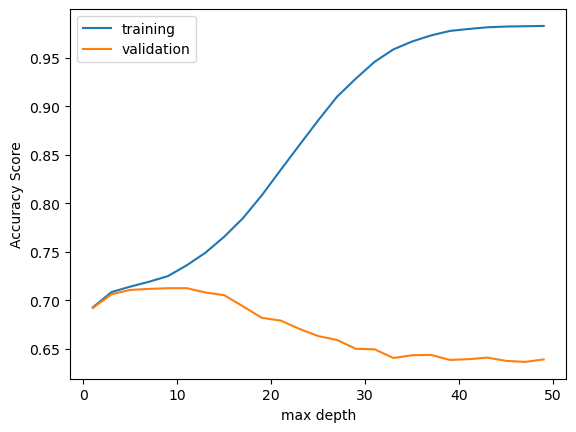

In [50]:
# `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams,training_acc,label ="training")
plt.plot(depth_hyperparams,validation_acc,label ="validation")
plt.xlabel("max depth")
plt.ylabel("Accuracy Score")
plt.legend ();

In [51]:
# the accuracy score
test_acc = model.score(X_test,y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.71


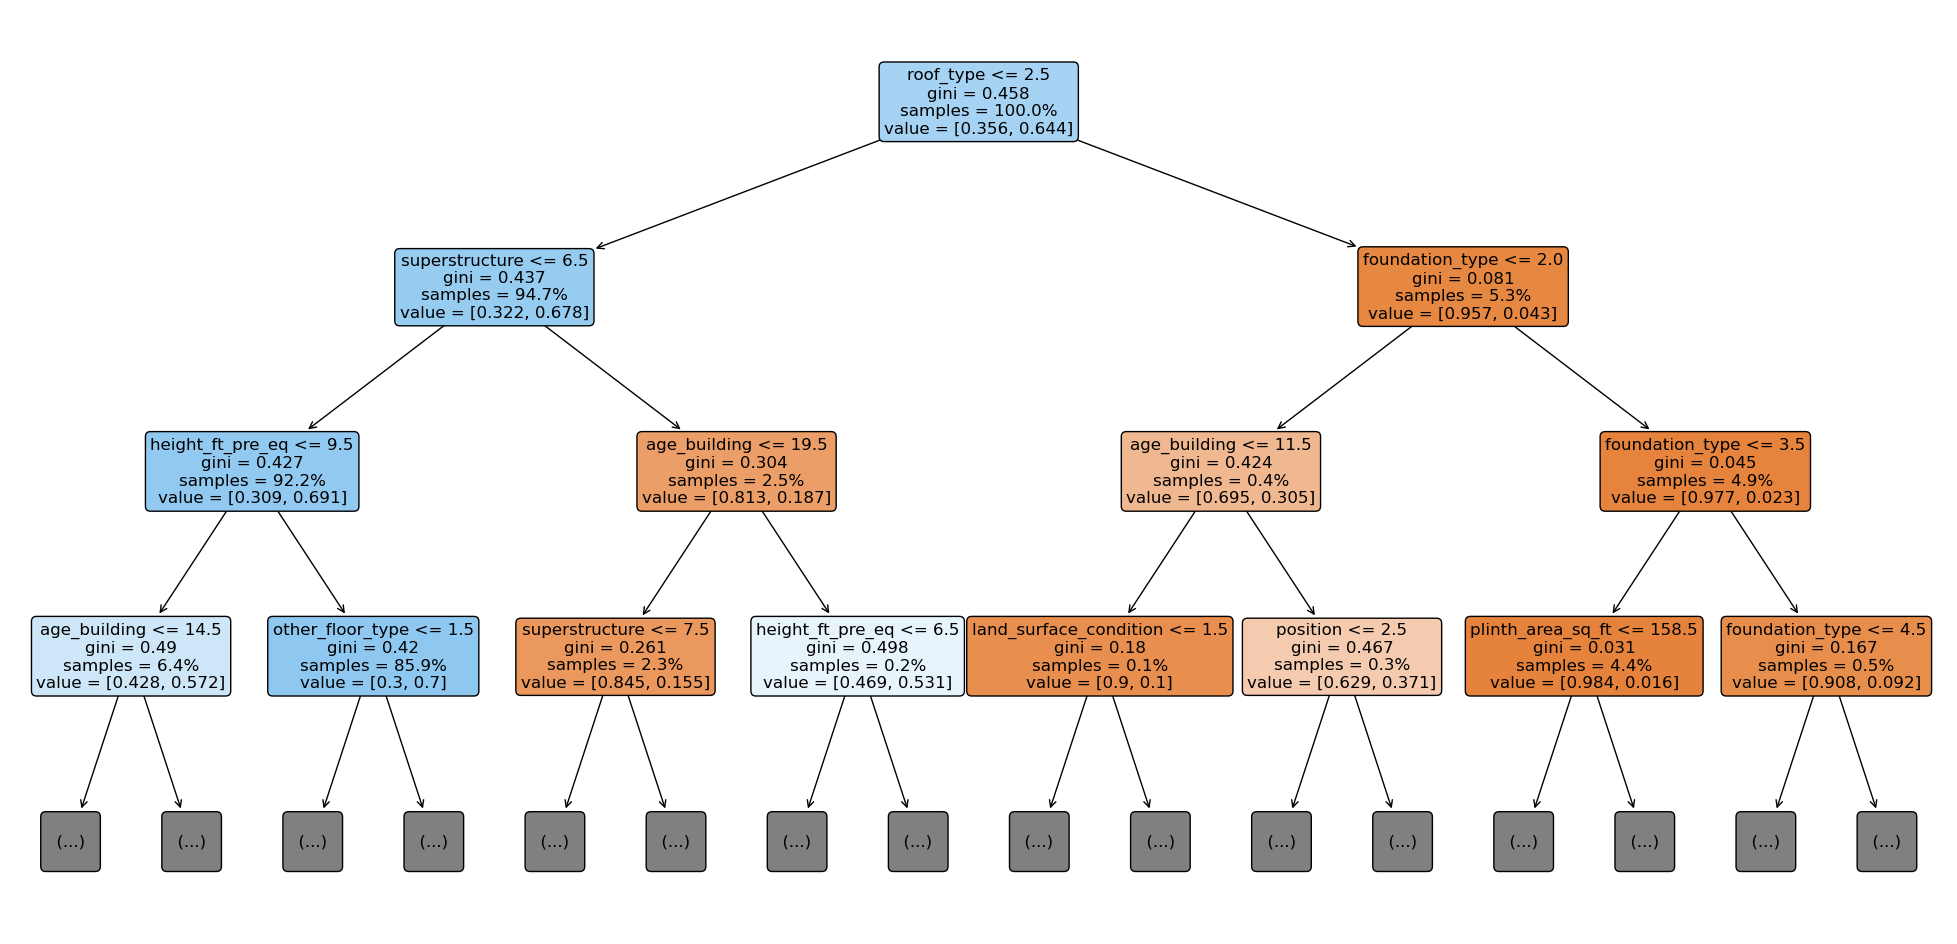

In [52]:
# Communicate
# Plot for the decision tree
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns ,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [53]:
# the feature names and importances
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_
print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.040339   0.02593112 0.0780057 ]


In [57]:
# feat_imp
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.head()

ground_floor_type         0.000000
land_surface_condition    0.000243
position                  0.001987
plan_configuration        0.003507
foundation_type           0.008884
dtype: float64

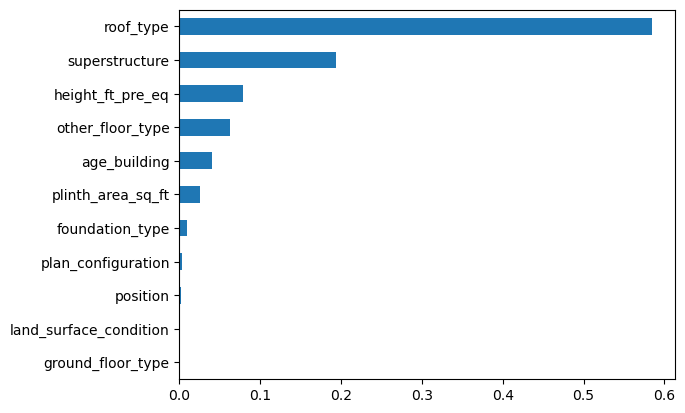

In [59]:
# horizontal bar chart for feat_imp
feat_imp.plot(kind="barh");